In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, accuracy_score, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier



### Ingesting data and data exploration

In [2]:


df = pd.read_csv('churn_data.csv', sep=';')

#new feature: overage fee to avg monthly bill ratio. we can assume lower bill = lower ability to pay or interest in the product. If the overage fee is a higher ratio compared to their bill, they could be disproportionately affected. 

df['overage_ratio'] = df['OverageFee'] / df['MonthlyCharge']

#df_outofdata = df.loc[(df['DataPlan'] == 0) & df['DataUsage'] > 0]

# we see there are about 600 people who are using data without a data plan, which I assume has higher fees.

df['out_of_plan_data_use'] = (df['DataPlan'] == 0) & (df['DataUsage'] > 0)
df['out_of_plan_data_use'] = df['out_of_plan_data_use'].astype(int)

#Roaming minutes are charged at higher rates than normal daytime minutes. Let's create another variable showing the ratio of roaming to daytime minutes

df['roaming_daytime_ratio'] = df['RoamMins'] / df['DayMins']
df['roaming_daytime_ratio'] = df['roaming_daytime_ratio'].replace(np.inf, 1, inplace=False)
df.describe()

# If the have a high monthly charge, and they have made a lot of calls, then I assume that they would have called to lower the monthly charge. Let's create an interaction term between these two
df['cs_calls_bill'] = df['CustServCalls'] * df['MonthlyCharge']

#daily call length. If they have longer calls per day, they may be business customers who have different needs than regular customers.
#df['daily_call_length'] = (df['DayMins'] / 30.417) * df['DayCalls']
#%%


/tmp/ipykernel_1229/69498618.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(np.array(df.iloc[i]), bw=0.5).set(title=cols[i])
/tmp/ipykernel_1229/69498618.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(np.array(df.iloc[i]), bw=0.5).set(title=cols[i])
/tmp/ipykernel_1229/69498618.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(np.array(df.iloc[i]), bw=0.5).set(title=cols[i])
/tmp/ipykernel_1

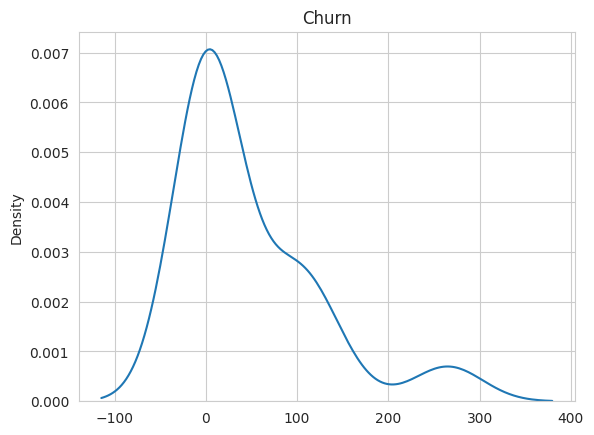

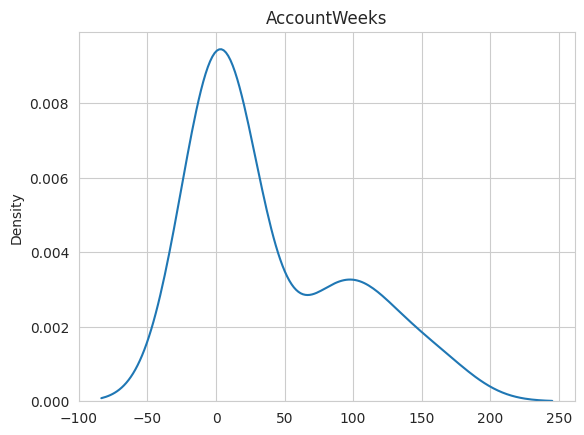

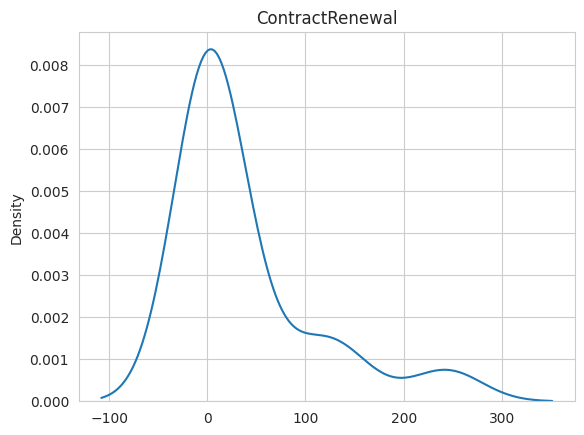

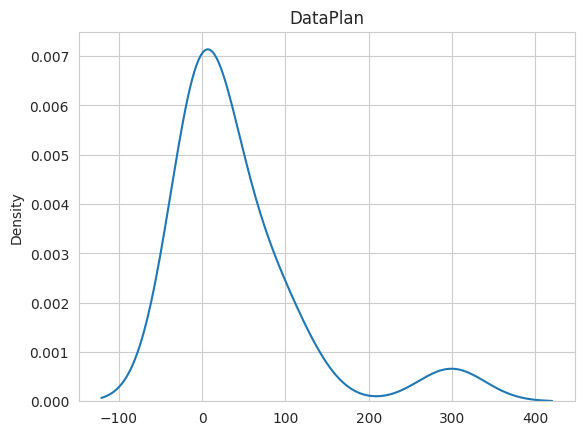

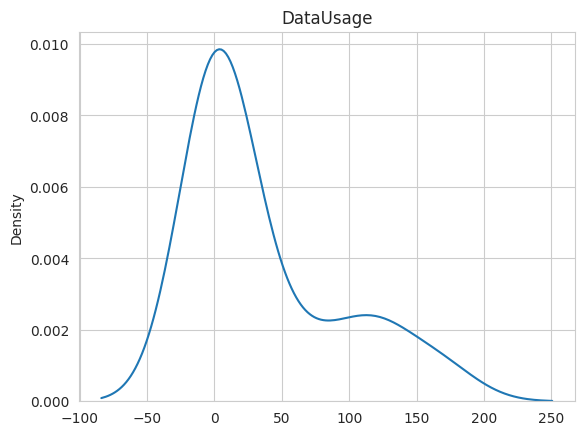

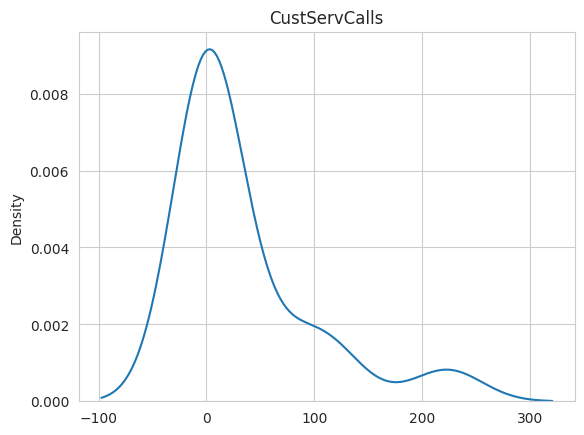

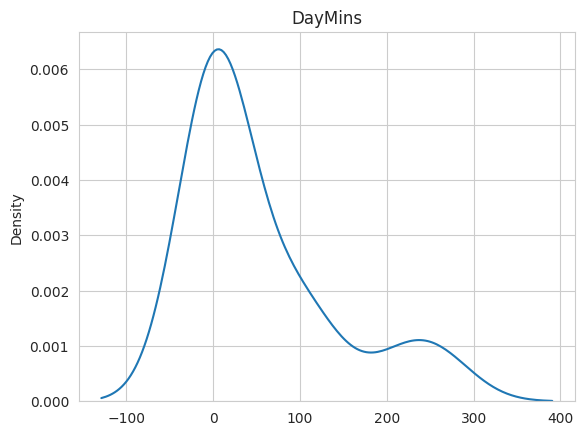

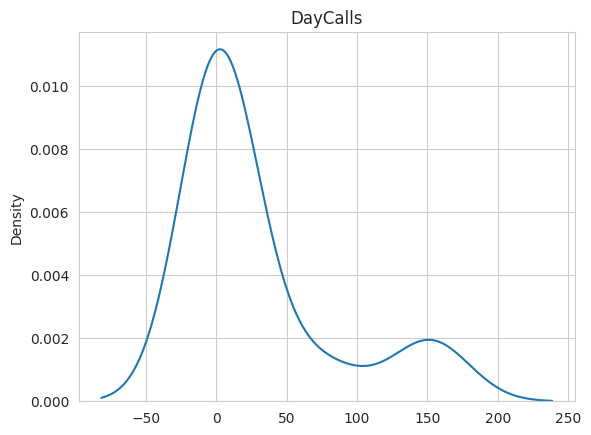

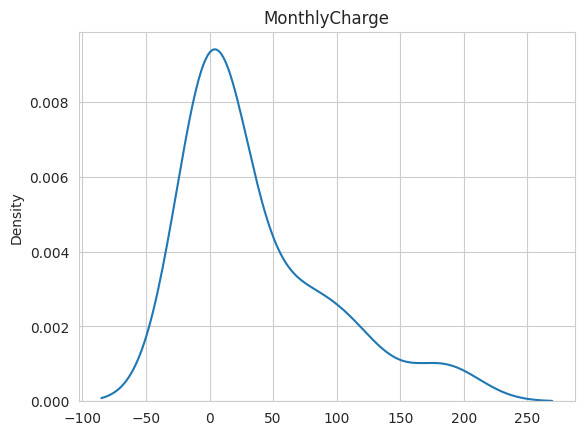

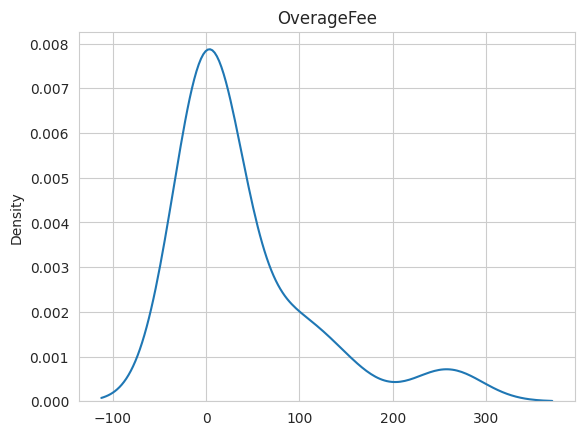

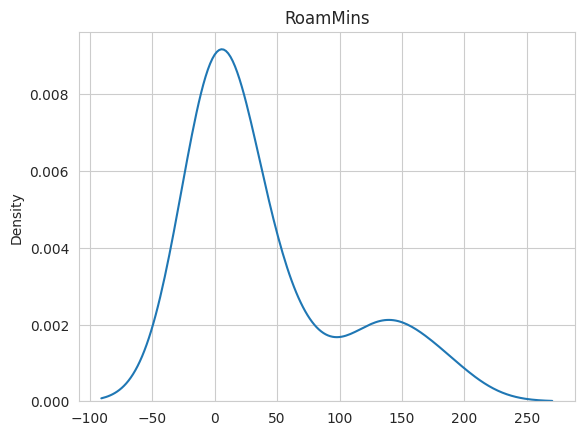

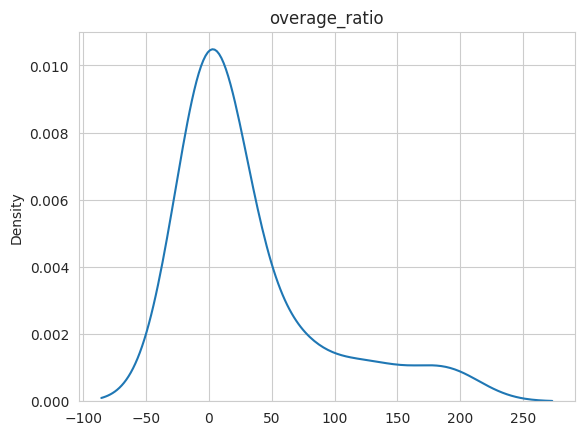

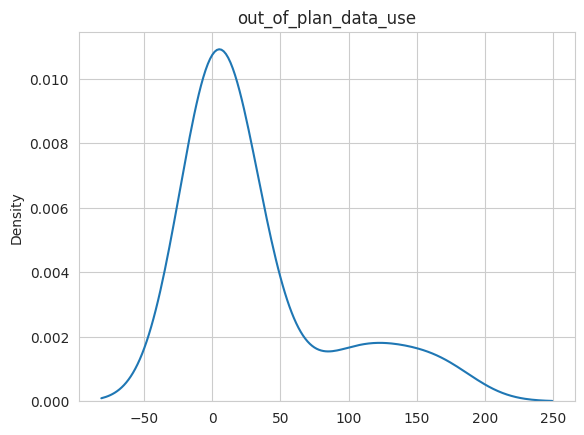

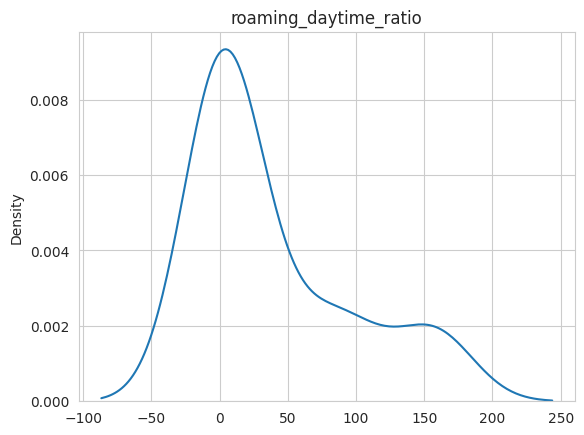

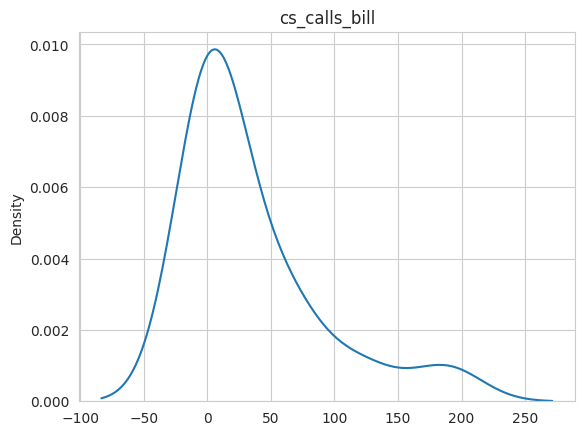

In [3]:

#TODO scale the distributions of continuous variables (will this make a difference?)
#%%
#now let's visualize all of our columns and check the distributions
sns.set_style('whitegrid')

cols = list(df.columns)
for i in range(len(cols)):
    plt.figure(i)
    sns.kdeplot(np.array(df.iloc[i]), bw=0.5).set(title=cols[i])


#%%


### Splitting the data

In [4]:

#Split features and target into X and y
features = df.drop(labels='Churn', axis=1)
X = np.array(features)
y = np.array(df['Churn'])
y_labels = np.array(['Not churn', 'Churn'])
#Create test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


### Modeling using a Decision Tree cLassifier

In [5]:

# Create a model using DecisionTree classifier
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=1)
clf_tree.fit(X_train, y_train)

# Predict test set labels
y_pred = clf_tree.predict(X_test)

 
# Compute test set accuracy  
acc_baseline = accuracy_score(y_test, y_pred)
print("Test set baseline accuracy: {:.3f}".format(acc_baseline))
#%%


Test set baseline accuracy: 0.917


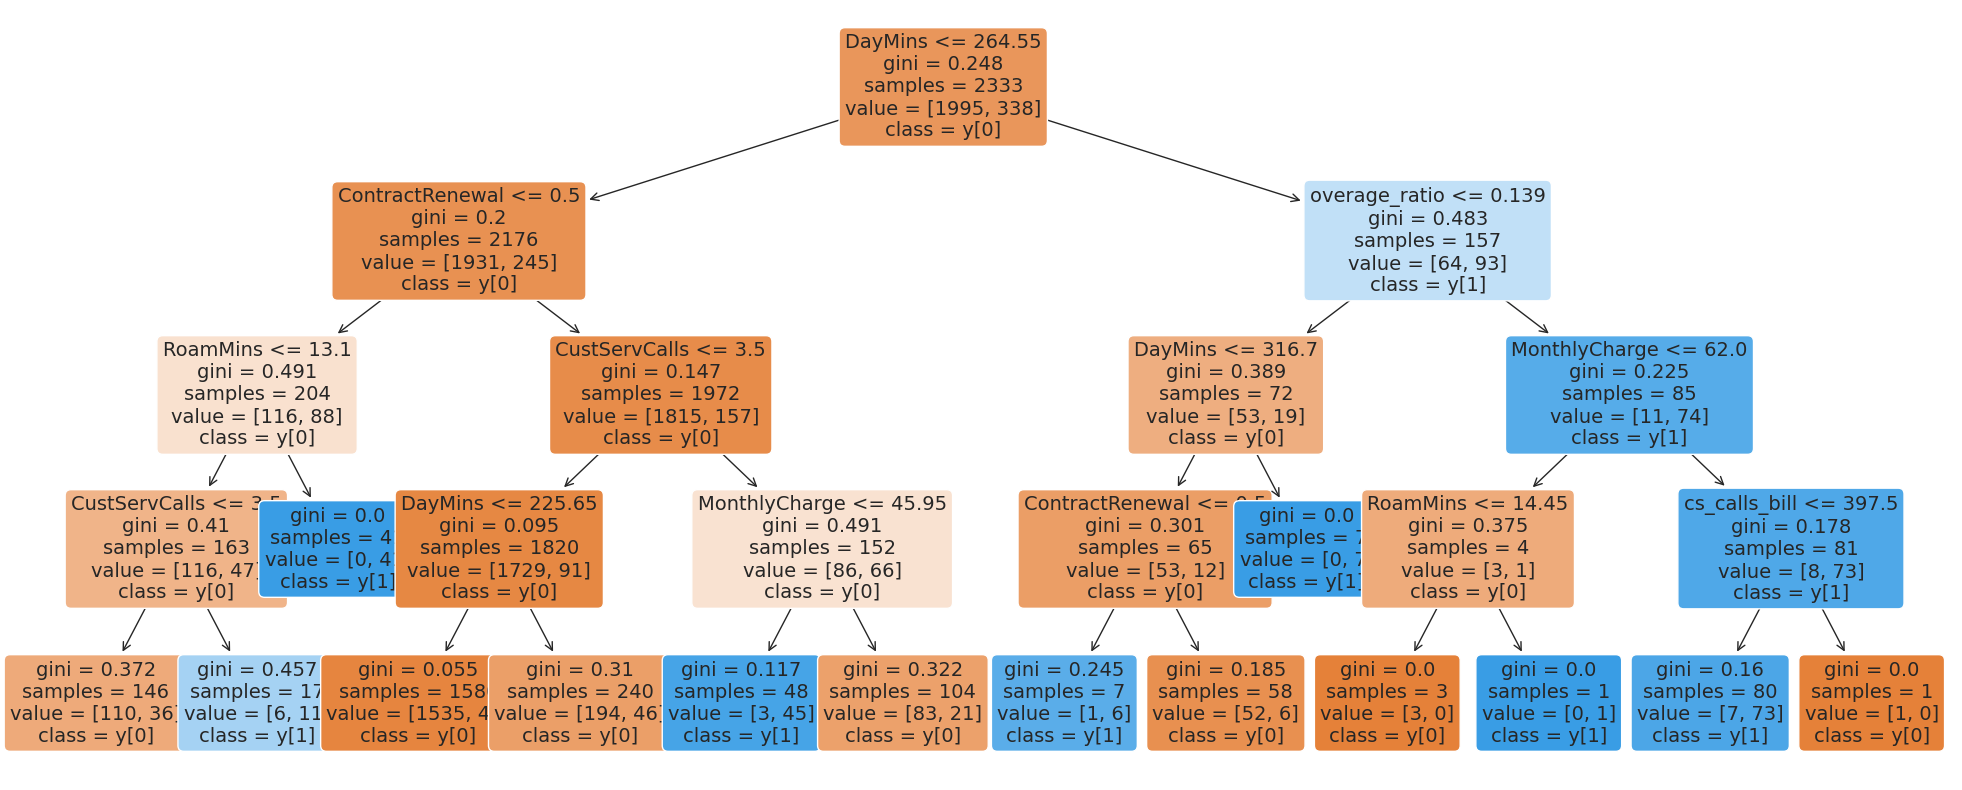

In [6]:
#Plot the tree
plt.figure(figsize=(25,10))

#This should work but it doesn't, wtf? 
#class_names = ['Not_churned', 'Churned']
plot_tree = plot_tree(clf_tree,
                      feature_names=features.columns, 
#                     class_names=class_names, 
                      class_names=True,
                      filled=True, 
                      rounded=True, 
                      fontsize=14)


#%%


### Using an Ensemble to try and improve accuracy

In [7]:
#Comparing the KNN and Decision Tree Classifiers individually first.

# Set seed for reproducibility
SEED=2345
 
# Instantiate knn
knn = KNN(n_neighbors=5)
 
# Instantiate tree
tree = DecisionTreeClassifier(min_samples_leaf = 0.13, random_state=SEED)
 
# Define the list classifiers
classifiers = [('K Nearest Neighbours', knn), ('Classifier Tree', tree)]


#
# Evaluate individual classifiers
#
from sklearn.metrics import accuracy_score
 
# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
  
    # Fit clf to the training set
    clf.fit(X_train, y_train)    

    # Predict y_pred
    y_pred = clf.predict(X_test)
     
    # Calculate accuracy
    acc_clf = accuracy_score(y_test, y_pred) 
    
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, acc_clf))
#%%


K Nearest Neighbours : 0.878
Classifier Tree : 0.855


In [8]:
#Now let's check if we can get a higher accuracy rating with ensembling

# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier
 
# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers, voting='soft')     
 
# Fit vc to the training set
vc.fit(X_train, y_train)   
 
# Evaluate the test set predictions
y_pred = vc.predict(X_test)
 
# Calculate accuracy score
acc_voting = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(acc_voting))
#Nope, doesn't seem like this will give us a better result. .858, so slightly better than knn but not enough to make a difference. 
#%%


Voting Classifier: 0.876


### Using Bagging to try and improve model accuracy

In [9]:
#Bagging
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
 
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier
 
# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)
 
# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=300, random_state=1)

# Fit bc to the training set
bc.fit(X_train, y_train)
 
# Predict test set labels
y_pred = bc.predict(X_test)
 
# Evaluate acc_test
acc_dt_with_bagging = accuracy_score(y_test, y_pred)
print('Test set accuracy of bc: {:.3f}'.format(acc_dt_with_bagging)) 
#Jump from 85.5% to 92.8% with bagging
#%%


Test set accuracy of bc: 0.930


In [10]:
#pass KNN into bagging
# Instantiate knn
#already done
 
# Instantiate bc
bc = BaggingClassifier(base_estimator=knn, n_estimators=100, random_state=1)

# Fit bc to the training set
bc.fit(X_train, y_train)
 
# Predict test set labels
y_pred = bc.predict(X_test)
 
# Evaluate acc_test
acc_knn_with_bagging = accuracy_score(y_test, y_pred)
print('Test set accuracy of knn with bagging: {:.3f}'.format(acc_knn_with_bagging))
#This gives us a slightly better model than using knn by itself, but still nowhere near as good as using random forest by itself. 
auc_knn_with_bagging = roc_auc_score(y_test, y_pred)
print("Test set AUC of knn_with_bagging: {:.3f}".format(auc_knn_with_bagging))

#%%


Test set accuracy of knn with bagging: 0.881
Test set AUC of knn_with_bagging: 0.667


### Using Random Forest Classifier to model the data

In [11]:
# Instantiate rf
rf = RandomForestClassifier(max_depth=12, random_state=0, n_estimators=500)
             
# Fit rf to the training set    
rf.fit(X_train, y_train) 
 
# Predict test set labels
y_pred = rf.predict(X_test)
 
# Evaluate acc_test
acc_rf = accuracy_score(y_test, y_pred)
print('Test set accuracy of rf: {:.3f}'.format(acc_rf)) 
#RF gets 93.5%

# Predict the test set labels
y_pred = rf.predict(X_test)
 
# Print ROC_AUC score

auc_rf = roc_auc_score(y_test, y_pred)
print("Test set AUC of rf: {:.3f}".format(auc_rf))
#up from 0.741 to 0.811
#%%


Test set accuracy of rf: 0.935
Test set AUC of rf: 0.807


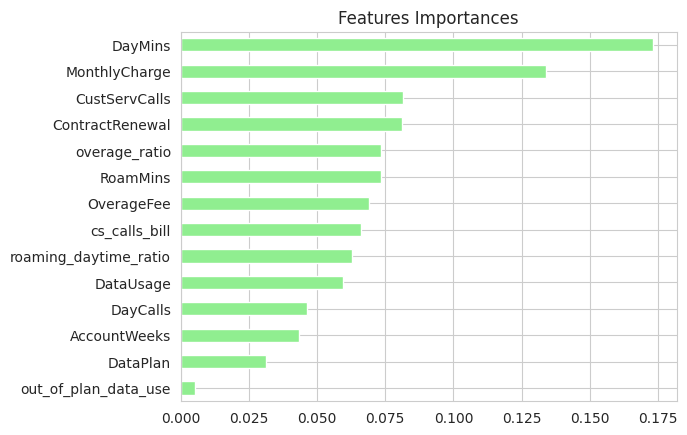

In [12]:
#Let's rank feature importance now.
# Create a pd.Series of features importances
importances = pd.Series(data = rf.feature_importances_,
                        index = features.columns)
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

#DayMins and MonthlyCharge are the most important feature, plus the daily_call_length feature I added. But that might be because daily_call_length is a function of DayMins
#%%


In [13]:
#Now let's try using AdaBoost to see if we can improve AUC
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
 
ada_reg = AdaBoostClassifier(n_estimators=100)

# Fit ada to the training set
ada_reg.fit(X_train, y_train)
 
# Compute the probabilities of obtaining the positive class
y_pred_ada = ada_reg.predict(X_test)

#Print ROC_AUC score
auc_ada = roc_auc_score(y_test, y_pred_ada)
print("Test set AUC of ada: {:.3f}".format(auc_ada))

#Ada brings it from 0.801 to 0.884, nice.


#%%


Test set AUC of ada: 0.702


In [14]:
#Now let's try XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1)

# Fit ada to the training set
xgb_model.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_xg = xgb_model.predict(X_test)

#Print ROC_AUC score

auc_xgb = roc_auc_score(y_test, y_pred)
print("Test set AUC of xgb: {:.3f}".format(auc_xgb))
#XGB worse than ada (.801 to 0.885)
#%%


Test set AUC of xgb: 0.807


In [15]:
#Hyperparameter tuning
# Instantiate rf
rf_2 = RandomForestClassifier(max_depth=2, random_state=0)
             
# Fit rf to the training set    
rf_2.fit(X_train, y_train) 
 
# Predict test set labels
y_pred = rf_2.predict(X_test)
 
# Evaluate acc_test
acc_test = accuracy_score(y_test, y_pred)
print('Test set accuracy of rf with max_depth_2: {:.4f}'.format(acc_test)) 

#evaluate ROC_AUC score
auc_rf_2 = roc_auc_score(y_test, y_pred)
print('Test set AUC of rf with max_depth_2 : {:.4f}'.format(auc_rf_2))
# Instantiate rf
rf_12 = RandomForestClassifier(max_depth=12, random_state=0)
             
# Fit rf to the training set    
rf_12.fit(X_train, y_train) 
 
# Predict test set labels
y_pred = rf_12.predict(X_test)
 
# Evaluate acc_test
acc_test = accuracy_score(y_test, y_pred)
print('Test set accuracy of rf with max_depth_12: {:.4f}'.format(acc_test)) 

#evaluate ROC_AUC score
auc_rf_12 = roc_auc_score(y_test, y_pred)
print('Test set AUC of rf with max_depth_12 : {:.4f}'.format(auc_rf_12))
#Optimal depth is at 12, gives us 93.5% accuracy
#But, 6 gives 92.5% accuracy. So 6 is more efficient
#seems like Ada gives the best AUC and rf gives the best accuracy. Can we use ada with rf?

# rf_accuracy = []
# for i in range(1,12):
#     rf_iterated = RandomForestClassifier(max_depth=i, random_state = 0)
#     rf_iterated.fit(X_train, y_train)
#     y_pred = rf_iterated.predict(X_test)
#     acc_test = accuracy_score(y_test, y_pred)
#     auc_rf_iterated = roc_auc_score(y_test, y_pred)
#%%


Test set accuracy of rf with max_depth_2: 0.8550
Test set AUC of rf with max_depth_2 : 0.5000
Test set accuracy of rf with max_depth_12: 0.9330
Test set AUC of rf with max_depth_12 : 0.8033


### Hyperparameter tuning

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': range(1,100),
    'max_features': ['log2', 'auto', 'sqrt'],
    'min_samples_leaf': [2, 10],
    'max_depth': [2, 12]}
rf_cvgrid = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator = rf_cvgrid, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 1, scoring = 'roc_auc')

grid_search.fit(X_train, y_train)

#evaluate accuracy
y_pred_opt = grid_search.predict(X_test)
rf_opt_acc = accuracy_score(y_test, y_pred_opt)
print('Test set accuraacy of rf optimized: {:.3f}'.format(rf_opt_acc))

#evaluate ROC_AUC score
auc_rf_opt = roc_auc_score(y_test, y_pred_opt)
print('Test set AUC of rf_opt : {:.4f}'.format(auc_rf_opt))

best_params = grid_search.best_params_
#%%


Fitting 5 folds for each of 1188 candidates, totalling 5940 fits


/home/djtom/bse/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/djtom/bse/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/djtom/bse/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

Test set accuraacy of rf optimized: 0.929
Test set AUC of rf_opt : 0.7752


In [ ]:
#Final model

def predictor_model(obs):
    #input must be array of 1,15
    obs_reshaped = np.array(obs).reshape(1,15)
    return obs_reshaped
